In [ ]:
%load_ext autoreload
%autoreload 2
# This is the calibration and rough wavefront supervision graph used for training the initial wavefront model 
# This graph is generated inside the WaveformVideoDataset class, and used to cache and output training batches
import numpy as np
from surfbreak.detection import detect_surfzone, trim_image
video_filepath='../../data/shirahama_1590387334_SURF-93cm.ts'

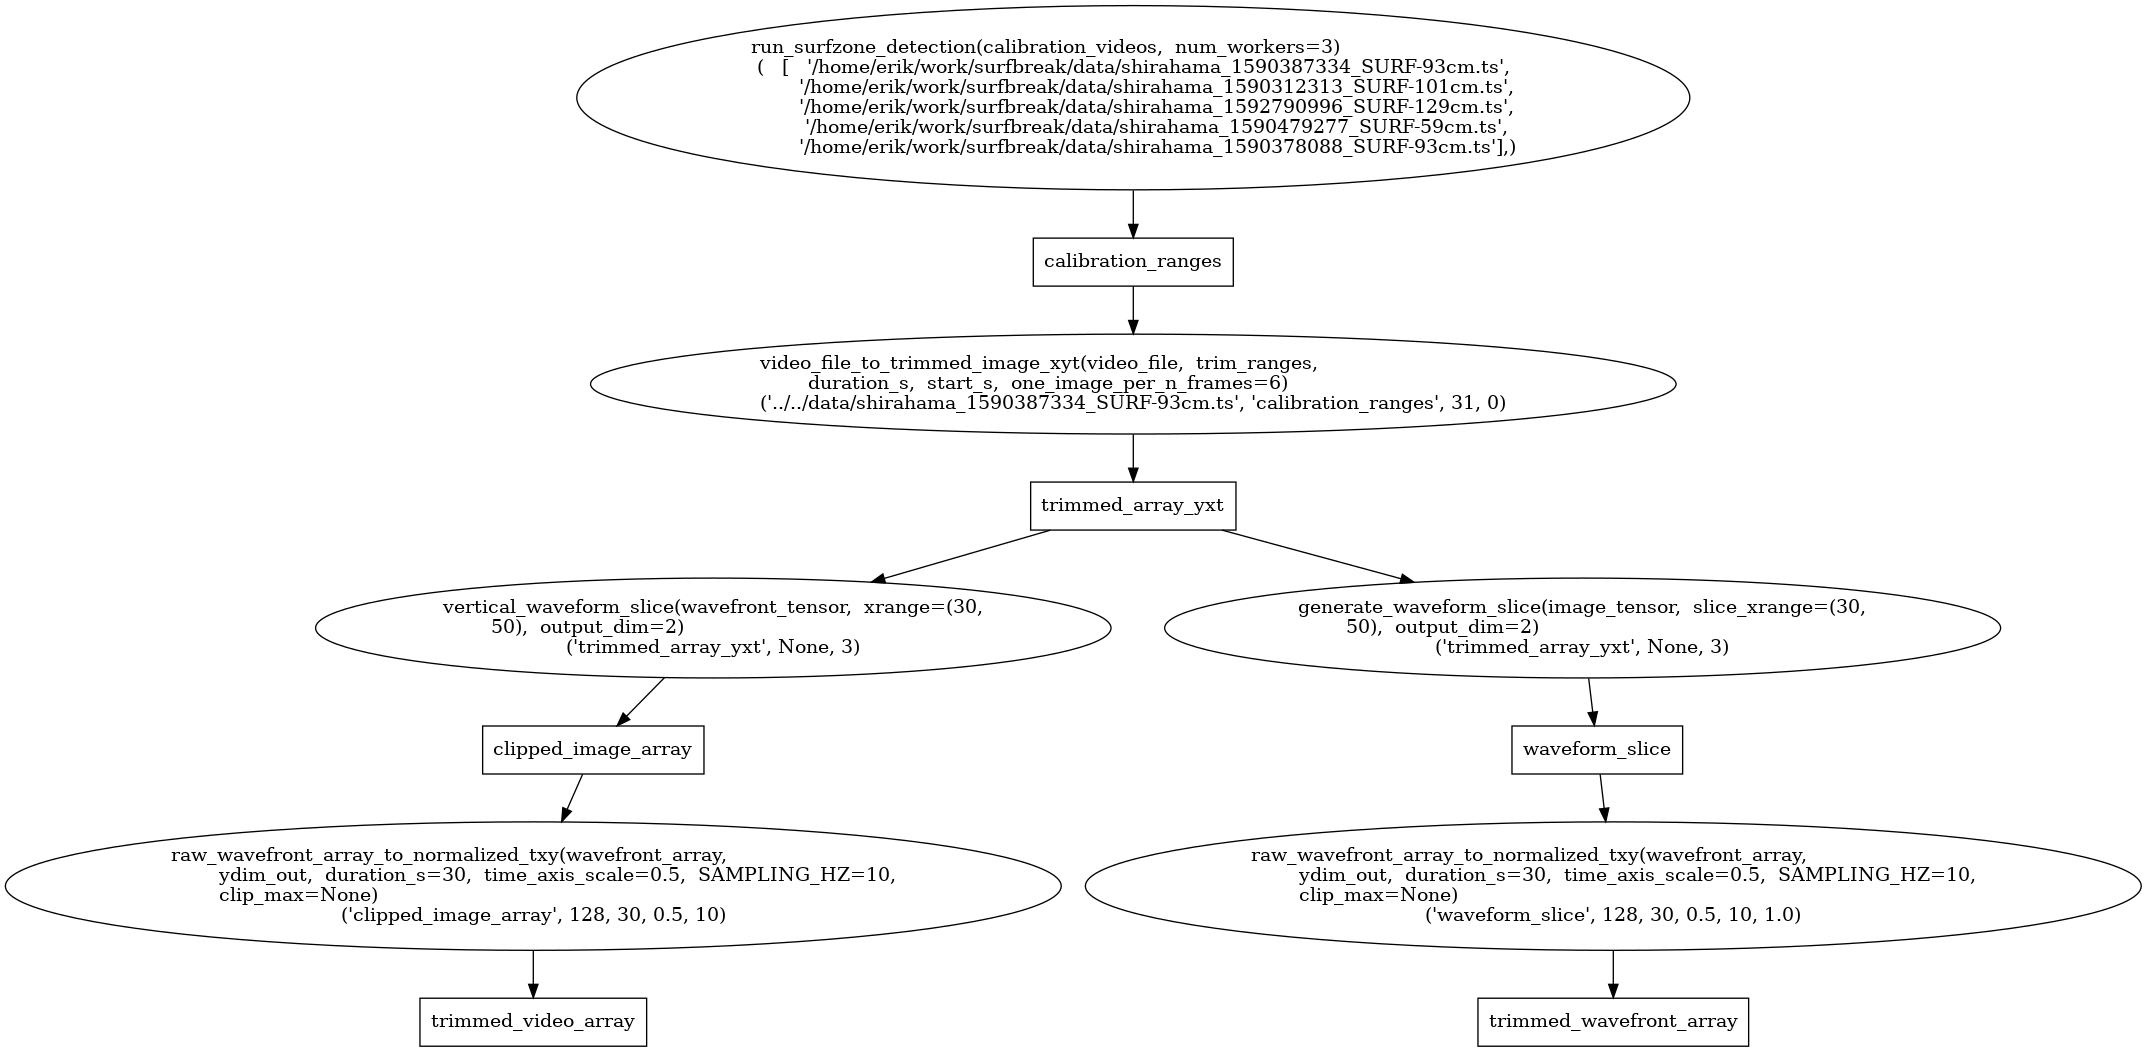

In [ ]:
from surfbreak.pipelines import video_to_waveform_array_txy
from surfbreak.graphutils import visualize
dask_graph = video_to_waveform_array_txy(video_filepath, ydim_out=128)
visualize(dask_graph, rankdir='UD')

(150, 1036, 128)


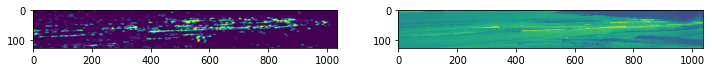

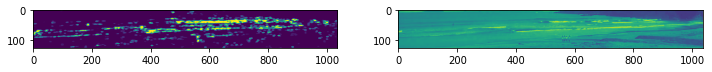

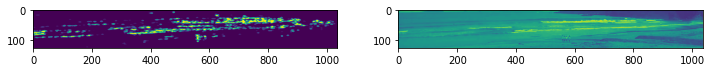

In [ ]:
import graphchain
import matplotlib.pyplot as plt
vid_array = graphchain.get(dask_graph, 'trimmed_video_array')
wavefront_array = graphchain.get(dask_graph, 'trimmed_wavefront_array')
print(vid_array.shape)
for t in range(3):
    fig, ax = plt.subplots(ncols=2, figsize=(12,3))
    ax[0].imshow(wavefront_array[t*5].T)
    ax[1].imshow(vid_array[t*5].T)
    plt.show()

## Now load pre-trained CNN for wavefront detection
Details can be found in [11_simple_wave_detector.ipynb](../11_simple_wave_detector.ipynb)

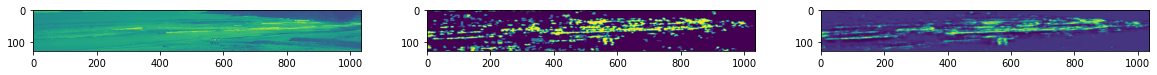

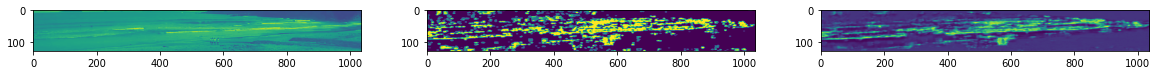

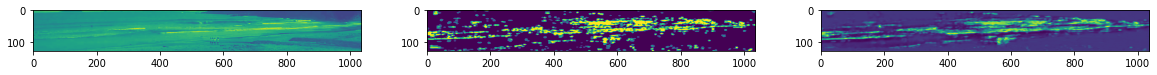

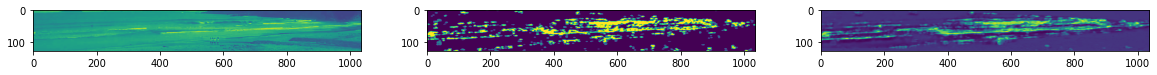

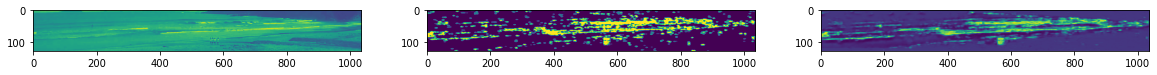

In [ ]:
from surfbreak.waveform_models import LitWaveCNN
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedCNNWavefrontDataset, InferredWavefrontDataset

video_filepath='../../data/shirahama_1590387334_SURF-93cm.ts'
cnn_checkpoint ='../../bestlogs/simplecnn/checkpoints/epoch=19.ckpt'

wfs_dataset = WavefrontSupervisionDataset(video_filepath, ydim=128, timerange=(0,3),
                                          time_chunk_duration_s=1, time_chunk_stride_s=1)
infwfs_dataset = InferredWavefrontDataset(wfs_dataset, cnn_checkpoint)

import matplotlib.pyplot as plt
wfs_in, wfs_gt = wfs_dataset[0]
inf_in, inf_gt = infwfs_dataset[0]

for t_idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(20,3))
    axes[0].imshow(wfs_gt["video_txy"][t_idx].T)
    axes[1].imshow(wfs_gt["wavefronts_txy"][t_idx].T)
    axes[2].imshow(inf_gt["wavefronts_txy"][t_idx].T)

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import WaveformNet
from surfbreak.datasets import CachedDataset
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedWavefrontDataset, InferredWavefrontDataset

training_video = '../../data/shirahama_1590387334_SURF-93cm.ts'
cnn_checkpoint ='../../bestlogs/simplecnn/checkpoints/epoch=19.ckpt'

max_epochs=6
wf_net_kwargs = dict(
    hidden_features=256,
    hidden_layers=3,
    first_omega_0=2.5,
    hidden_omega_0=11,
    squared_slowness=1.0, #0.2
    learning_rate=1e-4,
    wavefunc_loss_scale=1e-12, #1e-12, #5.5e-9,
    wavespeed_loss_scale=1e-13, #1e-15, #4e-4, 
    wavespeed_first_omega_0=0.5, #1.0, #3.5, 
    wavespeed_hidden_omega_0=2.0, #15, 
)

def train_wfmodel(training_video, cnn_checkpoint, max_epochs, wf_net_kwargs, start_minute=0):
    raw_wfs_dataset = WavefrontSupervisionDataset(training_video, timerange=(start_minute*60,(start_minute+2)*60), 
                                                  time_chunk_duration_s=1, time_chunk_stride_s=1)
    txy_cache = CachedDataset(InferredWavefrontDataset, raw_wfs_dataset, cnn_checkpoint)
    wf_train_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=0.5)
    wf_valid_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    viz_wftxy_dataset = WavefrontSupervisionDataset(training_video, timerange=(start_minute*60,(start_minute+1)*60), 
                                                  time_chunk_duration_s=30, time_chunk_stride_s=30)
    viz_inftxy_dataset = InferredWavefrontDataset(viz_wftxy_dataset, cnn_checkpoint)

    wavefunc_model = WaveformNet(train_dataset=wf_train_dataset, valid_dataset=wf_valid_dataset,
                                 viz_dataset=viz_inftxy_dataset, batch_size=64,
                                 **wf_net_kwargs)

    tb_logger = pl.loggers.TensorBoardLogger('logs/', name="wfnet")
    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=30,
                         max_epochs=max_epochs, # 20 
                         gpus=1 if torch.cuda.is_available() else None,
                         track_grad_norm=2)

    pl.seed_everything(42)
    trainer.fit(wavefunc_model)
    return wavefunc_model

In [ ]:
for sm in range(0,6,2):
    print("Start minute: ",sm)
    train_wfmodel(training_video, cnn_checkpoint, max_epochs, wf_net_kwargs, start_minute=sm)
print("Done")

Start minute:  0


/home/erik/.local/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           



Start minute:  2
Decoding ../../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           



Start minute:  4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           



Done


## Optimize via optuna

In [ ]:
import os
import torch
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback
from surfbreak.studies import run_waveform_hyperparam_search, MetricsCallback

from surfbreak.waveform_models import WaveformNet
from surfbreak.datasets import CachedDataset
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedWavefrontDataset, InferredWavefrontDataset

LOGDIR = 'logs'
MODELDIR = os.path.join(LOGDIR, 'opt_models')

def objective(trial):
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint( # Filenames for each trial must be made unique
        os.path.join(MODELDIR, "trial_{}".format(trial.number), "{epoch}"), monitor="val_loss")
    tb_logger = pl.loggers.TensorBoardLogger(LOGDIR+'/', name="optuna")
    metrics_callback = MetricsCallback()     # Simple callback that saves metrics from each validation step.
    pl.seed_everything(42)

    
    training_video = '../../data/shirahama_1590387334_SURF-93cm.ts'
    cnn_checkpoint ='../../bestlogs/simplecnn/checkpoints/epoch=19.ckpt'
    max_epochs=5
    wf_net_kwargs = dict(
        hidden_features=256,
        hidden_layers=3,
        first_omega_0=trial.suggest_uniform('first_omega_0', 0.1, 5.0), #1.5, 
        hidden_omega_0=trial.suggest_uniform('hidden_omega_0', 1, 30), #11.7,
        squared_slowness=1.0, #0.23,
        learning_rate=5e-5, 
        wavefunc_loss_scale=trial.suggest_loguniform('wavefunc_loss_scale', 5e-12, 1e-9), #5e-9,
        wavespeed_loss_scale=trial.suggest_loguniform('wavespeed_loss_scale', 1e-13, 1e-9), #1e-3
        wavespeed_first_omega_0=trial.suggest_uniform('wavespeed_first_omega_0',1e-3,1.0), #3.5, 
        wavespeed_hidden_omega_0=trial.suggest_uniform('wavespeed_hidden_omega_0',1e-3,5), #15, 
    )

    raw_wfs_dataset = WavefrontSupervisionDataset(training_video, timerange=(0,3*60), 
                                                  time_chunk_duration_s=1, time_chunk_stride_s=1)
    txy_cache = CachedDataset(InferredWavefrontDataset, raw_wfs_dataset, cnn_checkpoint)
    wf_train_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    wf_valid_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    viz_wftxy_dataset = WavefrontSupervisionDataset(training_video, timerange=(0,60), 
                                                  time_chunk_duration_s=30, time_chunk_stride_s=30)
    viz_inftxy_dataset = InferredWavefrontDataset(viz_wftxy_dataset, cnn_checkpoint)

    wavefunc_model = WaveformNet(train_dataset=wf_train_dataset, valid_dataset=wf_valid_dataset,
                                 viz_dataset=viz_inftxy_dataset, batch_size=64,
                                 **wf_net_kwargs)

    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=50,
                         max_epochs=max_epochs, # 20 
                         gpus=1 if torch.cuda.is_available() else None,
                         callbacks=[metrics_callback],
                         early_stop_callback=PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                        )
    trainer.fit(wavefunc_model)
    
    return metrics_callback.metrics[-1]["val_loss"].item()


study = run_waveform_hyperparam_search(objective, n_trials=100, timeout=8*60*60, model_dir=MODELDIR, 
                                       prune=True, n_startup_trials=3, n_warmup_steps=3)


/home/erik/.local/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-22 19:58:40,978] Finished trial#0 with value: 0.10892675817012787 with parameters: {'first_omega_0': 3.5161478069856007, 'hidden_omega_0': 7.203213668102646, 'wavefunc_loss_scale': 2.0640123404211263e-10, 'wavespeed_loss_scale': 1.9891501398977762e-10, 'wavespeed_first_omega_0': 0.9288293496357429, 'wavespeed_hidden_omega_0': 0.36427756436537106}. Best is trial#0 with value: 0.10892675817012787.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-22 21:07:09,235] Finished trial#1 with value: 0.10321111232042313 with parameters: {'first_omega_0': 2.072010718983098, 'hidden_omega_0': 10.6541245044595, 'wavefunc_loss_scale': 4.4233939174735666e-10, 'wavespeed_loss_scale': 1.4967051671183682e-13, 'wavespeed_first_omega_0': 0.20712973737535498, 'wavespeed_hidden_omega_0': 1.4564064805938013}. Best is trial#1 with value: 0.10321111232042313.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-22 22:18:42,986] Finished trial#2 with value: 0.1271689236164093 with parameters: {'first_omega_0': 4.385856747124167, 'hidden_omega_0': 4.27203142413775, 'wavefunc_loss_scale': 2.4359806385073786e-11, 'wavespeed_loss_scale': 6.609375433015798e-12, 'wavespeed_first_omega_0': 0.6332502600499981, 'wavespeed_hidden_omega_0': 4.843852042526337}. Best is trial#1 with value: 0.10321111232042313.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-22 23:27:07,640] Finished trial#3 with value: 0.11986599862575531 with parameters: {'first_omega_0': 2.7759546530325743, 'hidden_omega_0': 7.369612784674293, 'wavefunc_loss_scale': 8.989650186707778e-11, 'wavespeed_loss_scale': 3.2404809282065544e-13, 'wavespeed_first_omega_0': 0.9419460957971714, 'wavespeed_hidden_omega_0': 1.2393523037056788}. Best is trial#1 with value: 0.10321111232042313.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-23 00:32:31,500] Finished trial#4 with value: 0.06277575343847275 with parameters: {'first_omega_0': 2.9119590973933436, 'hidden_omega_0': 26.242096524439127, 'wavefunc_loss_scale': 5.9095600551105465e-12, 'wavespeed_loss_scale': 1.6254763608246969e-13, 'wavespeed_first_omega_0': 0.1672878552133094, 'wavespeed_hidden_omega_0': 1.9726751000120766}. Best is trial#4 with value: 0.06277575343847275.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-23 01:35:54,677] Finished trial#5 with value: 0.1111043319106102 with parameters: {'first_omega_0': 1.673788799861354, 'hidden_omega_0': 10.109462853800594, 'wavefunc_loss_scale': 9.024094414027201e-11, 'wavespeed_loss_scale': 3.904919106928768e-10, 'wavespeed_first_omega_0': 0.4786969341618424, 'wavespeed_hidden_omega_0': 2.344750981936503}. Best is trial#4 with value: 0.06277575343847275.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-23 02:37:46,162] Finished trial#6 with value: 0.13317355513572693 with parameters: {'first_omega_0': 0.48166922425521685, 'hidden_omega_0': 8.977443225786782, 'wavefunc_loss_scale': 6.986521082703214e-12, 'wavespeed_loss_scale': 6.48106758715011e-13, 'wavespeed_first_omega_0': 0.5520061004854435, 'wavespeed_hidden_omega_0': 4.779264303942346}. Best is trial#4 with value: 0.06277575343847275.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-23 03:39:24,277] Finished trial#7 with value: 0.08572056889533997 with parameters: {'first_omega_0': 0.5076472191116921, 'hidden_omega_0': 19.287452821927694, 'wavefunc_loss_scale': 1.4697731712839445e-10, 'wavespeed_loss_scale': 1.5206264881552793e-12, 'wavespeed_first_omega_0': 0.3537355843330266, 'wavespeed_hidden_omega_0': 0.7154780401295499}. Best is trial#4 with value: 0.06277575343847275.


Number of finished trials: 8
Best trial was #4:
  Value: 0.06277575343847275
  Params: 
    first_omega_0: 2.9119590973933436
    hidden_omega_0: 26.242096524439127
    wavefunc_loss_scale: 5.9095600551105465e-12
    wavespeed_loss_scale: 1.6254763608246969e-13
    wavespeed_first_omega_0: 0.1672878552133094
    wavespeed_hidden_omega_0: 1.9726751000120766
